# Developing Smoke Estimate

I now need to resolve how to estimate the smoke for my city. It seems reasonable that a large fire, that burns a large number of acres, and that is close to a city would put more smoke into a city than a small fire that is much further away. One task is to define my smoke estimate and then apply it to every fire for my city. Should my smoke estimate be cumulative during each year or somehow amortized over the fire season? I documented what goes into my decision making and what I did to create my smoke estimate.

In [1]:
# Import some standard python modules
import geojson
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Ignore warning messages to suppress unnecessary output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the 'all_fire_data_with_distance.csv' dataframe
df = pd.read_csv("../intermediate data/all_fire_data_with_distance.csv")

In [3]:
# Let's take a look at some of the quantitative aspects of df
df.describe()

,OBJECTID,USGS_Assigned_ID,Fire_Year,Fire_Polygon_Tier,GIS_Acres,GIS_Hectares,Circleness_Scale,Circle_Flag,Shape_Length,Shape_Area,Distance
count,77541.000000,77541.000000,77541.000000,77541.000000,7.754100e+04,77541.000000,77541.000000,6206.0,7.754100e+04,7.754100e+04,77541.000000
mean,70449.188997,70449.188997,2001.155763,2.867322,1.978018e+03,800.475310,0.475565,1.0,1.085214e+04,8.004753e+06,525.390174
std,36240.315076,36240.315076,14.671980,2.703977,1.411595e+04,5712.520854,0.260093,0.0,3.810319e+04,5.712521e+07,276.964076
min,14299.000000,14299.000000,1963.000000,1.000000,4.697010e-06,0.000002,0.000051,1.0,6.295036e-01,1.900813e-02,0.786694
25%,39442.000000,39442.000000,1990.000000,1.000000,1.647447e+01,6.666979,0.269300,1.0,1.301556e+03,6.666979e+04,318.864912
50%,65673.000000,65673.000000,2005.000000,1.000000,8.541125e+01,34.564708,0.441074,1.0,3.383467e+03,3.456471e+05,517.570270
75%,101823.000000,101823.000000,2013.000000,6.000000,5.755139e+02,232.902206,0.648328,1.0,9.582886e+03,2.329022e+06,693.994895
max,135061.000000,135061.000000,2020.000000,8.000000,1.032651e+06,417899.203637,0.997980,1.0,3.769124e+06,4.178992e+09,1249.974573


In [4]:
# We also want to take a look at how df looks like
df.head()

,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,...,Wildfire_Notice,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,Distance
0,14299,14299,Wildfire,1963,1,"1 (1), 3 (3)",40992.458271,16589.059302,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.385355,NaN,No,73550.428118,1.658906e+08,557.889821
1,14300,14300,Wildfire,1963,1,"1 (1), 3 (3)",25757.090203,10423.524591,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (2)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.364815,NaN,No,59920.576713,1.042352e+08,569.857280
2,14301,14301,Wildfire,1963,1,"1 (5), 3 (15), 5 (1)",45527.210986,18424.208617,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (6), Likely Wildfire (15)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.320927,NaN,No,84936.827810,1.842421e+08,566.765526
3,14302,14302,Wildfire,1963,1,"1 (1), 3 (3), 5 (1)",10395.010334,4206.711433,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (2), Likely Wildfire (3)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.428936,NaN,No,35105.903602,4.206711e+07,502.738384
4,14303,14303,Wildfire,1963,1,"1 (1), 3 (3)",9983.605738,4040.221900,Comb_National_NIFC_Interagency_Fire_Perimeter_...,"Wildfire (1), Likely Wildfire (3)",...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,NaN,NaN,0.703178,NaN,No,26870.456126,4.040222e+07,553.362684


In [5]:
# We also want to look at all the columns of df and their dtype
df.dtypes

OBJECTID                          int64
USGS_Assigned_ID                  int64
Assigned_Fire_Type               object
Fire_Year                         int64
Fire_Polygon_Tier                 int64
Fire_Attribute_Tiers             object
GIS_Acres                       float64
GIS_Hectares                    float64
Source_Datasets                  object
Listed_Fire_Types                object
Listed_Fire_Names                object
Listed_Fire_Codes                object
Listed_Fire_IDs                  object
Listed_Fire_IRWIN_IDs            object
Listed_Fire_Dates                object
Listed_Fire_Causes               object
Listed_Fire_Cause_Class          object
Listed_Rx_Reported_Acres         object
Listed_Map_Digitize_Methods      object
Listed_Notes                     object
Processing_Notes                 object
Wildfire_Notice                  object
Prescribed_Burn_Notice           object
Wildfire_and_Rx_Flag             object
Overlap_Within_1_or_2_Flag       object


First lets take a look at the correlations using a heat map.

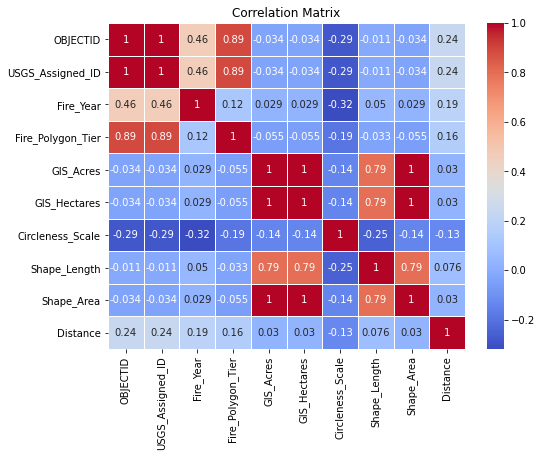

In [6]:
# Compute and generate a heatmap to look at initial correlations
df_without_circle_flag = df.copy()
df_without_circle_flag = df_without_circle_flag.drop(columns=["Circle_Flag"])
# Select only numeric columns
numeric_columns = df_without_circle_flag.select_dtypes(include=['number'])
# Compute the correlation matrix
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

The generated heatmap does not provide much helpful information to decide the factors we need to choose for the smoke estimate. Before we proceed further, lets ensure that there are no NaN or Null values in some of the columns we are interested in.

In [7]:
# Check for null and NaN values in 'Assigned_Fire_Type', 'GIS_Acres', and 'Distance' columns
null_values = df[['Assigned_Fire_Type', 'GIS_Acres', 'Distance']].isnull().sum()
nan_values = df[['Assigned_Fire_Type', 'GIS_Acres', 'Distance']].isna().sum()
# Check if any null or NaN values exist
if null_values.any() or nan_values.any():
    print("Null or NaN values found in the following columns:")
    print(null_values)
    print(nan_values)
else:
    print("No null or NaN values found in the specified columns.")

No null or NaN values found in the specified columns.


This smoke estimation is based on a combination of factors, including fire type, the size of the fire in square miles, and the distance from the fire. The reasoning behind this approach is as follows:

1. Different types of fires, such as wildfires and prescribed fires, can have varying degrees of impact on air quality and the environment. By assigning weightages to each fire type, I account for their varying impact levels. For instance, wildfires are assigned a higher weight of 1.0, while prescribed fires, which are controlled burns, have a lower weight of 0.5.

2. The size of the fire, represented in GIS acres, is an important factor in estimating smoke impact. Larger fires tend to produce more smoke, and this code takes this into consideration by multiplying the fire size by a conversion factor (0.0015625) to convert acres to square miles.

3. The distance from the fire source is another crucial factor. The code divides the smoke impact by the distance from the fire to account for the dispersion and dilution of smoke as it travels away from the source. This provides a more realistic estimate of the environmental impact based on proximity to the fire.

4. I also multiplied the obtained smoke estimate by a factor of 10000 to make it inline with the AQI values obtained so that the plots are properly visible. However, this will have no impact on the correlation.

5. To provide a summary of the smoke impact over time, the code groups the data by year and calculates the mean values for smoke impact, fire size, and distance. This aggregated data in the annual_smoke_estimate DataFrame allows for tracking and comparing the yearly variations in smoke impact.

In [8]:
# Creating a copy of the original dataframe
df_1 = df.copy()

# Define weightage for fire types
fire_type_weights = {
    'Wildfire': 1.0,
    'Unknown - Likely Wildfire': 0.9,
    'Likely Wildfire': 0.9,
    'Prescribed Fire': 0.5,
    'Unknown - Likely Prescribed Fire': 0.4
}

# Create a function to calculate smoke impact for each fire
def calculate_smoke_impact(row):
    # Calculate smoke impact based on fire type, acres, and distance
    impact = fire_type_weights.get(row['Assigned_Fire_Type'], 0) * row['GIS_Acres'] * 15.625 / row['Distance']
    return impact

# Apply the calculate_smoke_impact function to each row
df_1['Smoke_Impact'] = df_1.apply(calculate_smoke_impact, axis=1)
# Group the data by year and calculate the means for Smoke_Impact, GIS_Acres, and Distance and 
# rename the columns for the final DataFrame
annual_smoke_estimate = df_1.groupby('Fire_Year').agg({'Smoke_Impact': 'mean', 'GIS_Acres': 'mean', 'Distance': 'mean'}).reset_index()
annual_smoke_estimate.rename(columns={'Fire_Year': 'Year', 'Smoke_Impact': 'Smoke_estimate', 'GIS_Acres': 'Mean_GIS_Acres', 'Distance': 'Mean_Distance'}, inplace=True)

In [9]:
# Display the annual smoke estimate
annual_smoke_estimate

,Year,Smoke_estimate,Mean_GIS_Acres,Mean_Distance
0,1963,29.330028,692.523541,460.364545
1,1964,83.385196,1228.500535,449.245978
2,1965,29.389301,751.960342,392.174202
3,1966,110.492635,1703.514155,417.198627
4,1967,71.177229,1138.977416,376.275618
5,1968,82.640875,829.369066,329.456935
6,1969,52.392737,636.838619,354.550404
7,1970,158.364925,1803.417603,446.231921
8,1971,59.563782,1538.743198,464.962577
9,1972,36.303730,836.707448,378.992573


In [16]:
annual_smoke_estimate.to_csv("../intermediate data/annual_smoke_estimate.csv")

## Developing Prediction Model

I need to develop a predictive model based on the fire data and smoke estimate for my assigned city. My model will predict smoke estimates for every year for the next 25 years (i.e., 2024-2049). I should be careful to make sure my predictions convey appropriate levels of uncertainty in the prediction.

To develop a predictive model for smoke estimates for the next 25 years (2024-2049) based on the provided data, I will use an ARIMA model, which is a common choice for time series prediction. To convey appropriate levels of uncertainty, I will also calculate prediction intervals with a 95% confidence level.

The "order" in an ARIMA model is typically represented as (p, d, q), where:

- "p" is the order of the autoregressive (AR) component.
- "d" is the degree of differencing required to make the time series stationary.
- "q" is the order of the moving average (MA) component.

I will therefore perform a grid search over the specified values of (p, d, q) and select the combination that results in the lowest average RMSE over the 5 folds.

In [10]:
# Define a function to fit an ARIMA model and calculate RMSE

# Extract the 'Smoke_estimate' column from the training and test data
# Create an ARIMA model with the specified order
# Fit the ARIMA model to the training data
# Forecast values for the test data
# Calculate and return the Root Mean Squared Error (RMSE) to assess the model's accuracy
def fit_arima_and_calculate_rmse(train_data, test_data, order):
    # Use only the 'Smoke_estimate' column
    train_data = train_data['Smoke_estimate']
    test_data = test_data['Smoke_estimate']
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_data))
    rmse = sqrt(mean_squared_error(test_data, forecast))
    return rmse

# Define a range of values for (p, d, q) to explore
p_values = range(4, 10)
d_values = range(1, 5)
q_values = range(4, 8)
# Initialize variables to keep track of the best parameters and RMSE
best_rmse = float('inf')
best_order = None
# Splitting the data into 5 equal-sized folds
num_folds = 5
fold_size = len(annual_smoke_estimate) // num_folds

for p in p_values:
    for d in d_values:
        for q in q_values:
            # Accumulate RMSE across folds
            rmse_sum = 0
            for i in range(num_folds):
                start_idx = i * fold_size
                end_idx = (i + 1) * fold_size
                test_fold = annual_smoke_estimate[start_idx:end_idx]
                train_fold = pd.concat([annual_smoke_estimate[:start_idx], annual_smoke_estimate[end_idx:]])
                rmse_fold = fit_arima_and_calculate_rmse(train_fold, test_fold, order=(p, d, q))
                rmse_sum += rmse_fold
            avg_rmse = rmse_sum / num_folds
            # Update best parameters if a lower RMSE is found
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_order = (p, d, q)
            # Print the results for each combination
            print(f'p: {p}, d: {d}, q: {q}, RMSE: {avg_rmse}')

# Display the best ARIMA order and the corresponding average RMSE
print(f"Best ARIMA order: {best_order}")
print(f"Best average RMSE: {best_rmse}")

p: 4, d: 1, q: 4, RMSE: 43.35479381072501
p: 4, d: 1, q: 5, RMSE: 40.55348959394642
p: 4, d: 1, q: 6, RMSE: 38.4859945333872
p: 4, d: 1, q: 7, RMSE: 42.7263513159995
p: 4, d: 2, q: 4, RMSE: 48.35810665857274
p: 4, d: 2, q: 5, RMSE: 57.89532833986095
p: 4, d: 2, q: 6, RMSE: 58.441811933343935
p: 4, d: 2, q: 7, RMSE: 58.4295719550842
p: 4, d: 3, q: 4, RMSE: 101.73340787665553
p: 4, d: 3, q: 5, RMSE: 91.9663167448089
p: 4, d: 3, q: 6, RMSE: 87.31463899154866
p: 4, d: 3, q: 7, RMSE: 80.20137022851544
p: 4, d: 4, q: 4, RMSE: 185.08218300431923
p: 4, d: 4, q: 5, RMSE: 193.26642320973133
p: 4, d: 4, q: 6, RMSE: 219.45403180174736
p: 4, d: 4, q: 7, RMSE: 180.29886229526355
p: 5, d: 1, q: 4, RMSE: 50.763120375270844
p: 5, d: 1, q: 5, RMSE: 42.02176794942328
p: 5, d: 1, q: 6, RMSE: 41.74007147160555
p: 5, d: 1, q: 7, RMSE: 39.888277982178714
p: 5, d: 2, q: 4, RMSE: 51.48677697772619
p: 5, d: 2, q: 5, RMSE: 53.69209480591722
p: 5, d: 2, q: 6, RMSE: 53.08186488101494
p: 5, d: 2, q: 7, RMSE: 59.756

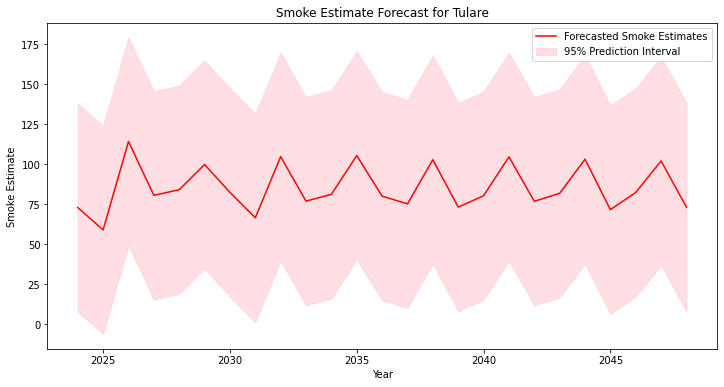

In [11]:
# Define a function to fit an ARIMA model and predict future values
def fit_arima_and_forecast(data, order, forecast_steps):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=forecast_steps)
    # Calculate the standard error and confidence intervals manually
    resid = model_fit.resid
    stderr = np.std(resid)
    conf_int = np.column_stack((forecast - stderr * 1.96, forecast + stderr * 1.96))
    return forecast, stderr, conf_int

# Training the ARIMA model on the historical data (e.g., 1963-2020) and forecast the next 25 years
order = best_order
forecast_steps = 25
historical_data = annual_smoke_estimate['Smoke_estimate']
forecast, stderr, conf_int = fit_arima_and_forecast(historical_data, order, forecast_steps)

# Create a DataFrame for the forecasted values
years_to_forecast = range(2024, 2049)
forecasted_data = pd.DataFrame({'Year': years_to_forecast, 'Forecasted_Smoke': forecast})

# Calculate the upper and lower bounds for prediction intervals
alpha = 0.05
lower_bound = forecast - stderr * 1.96
upper_bound = forecast + stderr * 1.96

# Add the calculated standard error and confidence intervals to the forecasted data
forecasted_data['Lower_Bound'] = lower_bound
forecasted_data['Upper_Bound'] = upper_bound

forecasted_data.reset_index(drop=True, inplace=True)

# Plot the forecasted values along with prediction intervals
plt.figure(figsize=(12, 6))
plt.plot(forecasted_data['Year'], forecasted_data['Forecasted_Smoke'], label='Forecasted Smoke Estimates', color='red')
plt.fill_between(forecasted_data['Year'], forecasted_data['Lower_Bound'], forecasted_data['Upper_Bound'], color='pink', alpha=0.5, label='95% Prediction Interval')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.title('Smoke Estimate Forecast for Tulare')
plt.legend()
plt.show()

In [15]:
# Visualize forecasted_data
forecasted_data

,Year,Forecasted_Smoke,Lower_Bound,Upper_Bound
0,2024,72.908043,7.968958,137.847128
1,2025,58.972234,-5.966851,123.911319
2,2026,114.111735,49.172650,179.050820
3,2027,80.527729,15.588644,145.466814
4,2028,84.061316,19.122231,149.000401
5,2029,99.766211,34.827126,164.705296
6,2030,82.427225,17.488140,147.366310
7,2031,66.533649,1.594564,131.472734
8,2032,104.684571,39.745486,169.623657
9,2033,76.908093,11.969008,141.847178


## Visualization Aspects of Analysis
Below are three time series graphs to illustrate the work of the above analysis. The wildfire data is annual, so the time series will be on an annual basis. All the time series should cover the analysis range defined above, but not the prediction range:

- Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.
- Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.
- Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city (present on the Compare_Smoke_Estimate_With_AQI.ipynb file).

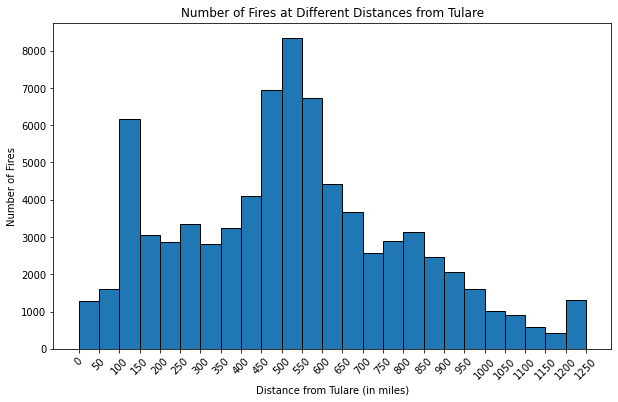

In [13]:
distance_column = "Distance"
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(df[distance_column], bins=range(0, 1300, 50), edgecolor='k')
plt.xlabel('Distance from Tulare (in miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Fires at Different Distances from Tulare')
# Customize the x-axis labels for better readability
xticks_labels = [str(i) for i in range(0, 1300, 50)]
plt.xticks(range(0, 1300, 50), xticks_labels, rotation=45)
plt.show()

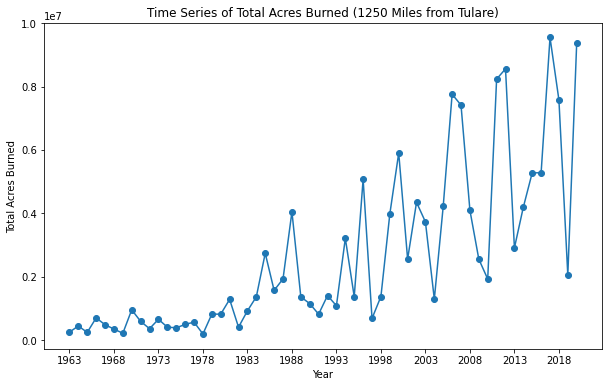

In [14]:
year_column = "Fire_Year"
acres_burned_column = "GIS_Acres"
# Define the specified distance (e.g., 1250 miles from your city)
specified_distance = 1250
# Filter the DataFrame to include only fires within the specified distance
filtered_df = df[df["Distance"] <= specified_distance]
# Group the filtered data by year and sum the acres burned in each year
annual_acres_burned = filtered_df.groupby(year_column)[acres_burned_column].sum()
# Create a time series plot
plt.figure(figsize=(10, 6))
plt.plot(annual_acres_burned.index, annual_acres_burned.values, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title(f'Time Series of Total Acres Burned ({specified_distance} Miles from Tulare)')
# Set the x-axis to show years with a 5-year gap
plt.xticks(range(min(annual_acres_burned.index), max(annual_acres_burned.index), 5))
plt.show()